# Setup

In [25]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline

In [27]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy

from relaxed import halo_parameters, halo_catalogs, analysis
import warnings

# Fits to obtain alpha

With Phil, I already discussed how adding $\beta$ to the fitting procedure does not contribute much because it has a strong degeneracy with $\alpha$. So in the following notebook we only use $\alpha$ for the fit. 

**Notes:**

 - There are two data points that don't reach a_{1/2} ever, this explains the runtime error below when obtaining a_{1/2}

In [28]:
from relaxed.progenitors.catalog import get_alpha, lma_fit
from relaxed.analysis import setup, get_ma
from relaxed.halo_parameters import get_hparam

In [29]:
hcat, indices, scales = setup('m11')
zs = (1/ scales) -1 
ma = get_ma(hcat.cat, indices)
lma = np.log(ma)[:, :160] # towards very big scales many masses become really close to 0. 

# remove infs 
keep = np.zeros(len(hcat.cat))
for indx in range(len(lma)):
    if np.isinf(lma[indx]).sum() == 0 and np.isnan(lma[indx]).sum() == 0: 
        keep[indx] = 1

keep = keep.astype(bool)
hcat.cat = hcat.cat[keep]
ma = ma[keep]
lma = lma[keep]
n = lma.shape[1]
zs = zs[:n]
print(len(hcat.cat))
print(lma.shape)
print(zs.shape)

9615
(9615, 160)
(160,)


In [30]:
# calculate all alpha, betas and add them to table. 
alphas = [] 
for idx in range(len(hcat.cat)):
    alpha = get_alpha(zs, lma[idx])
    alphas.append(alpha)
c1 = astropy.table.Column(alphas, name='alpha')
hcat.cat.add_column(c1)

In [31]:
# add a1/2 
from relaxed.analysis import get_a2
a2 = get_a2(hcat.cat, scales, indices)
c = astropy.table.Column(a2, name='a2')
hcat.cat.add_column(c)

# Plot more complete correlation matrix

In [32]:
plt.rc('text', usetex=True)

In [33]:
from scipy.stats import spearmanr

def plot_correlation_matrix(ax, values, cell_text_size=14):
    # values: list of values of ech para
    n_params = len(values)
    matrix = np.zeros((n_params, n_params))

    for i, value1 in enumerate(values):
        for j, value2 in enumerate(values):
            matrix[i, j] = spearmanr(value1, value2)[0]

    # mask out lower off-diagonal elements if requested.
    im = ax.matshow(matrix, cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)

    # add the values to each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            _ = ax.text(
                j,
                i,
                round(matrix[i, j], 2),
                ha="center",
                va="center",
                color="k",
                size=cell_text_size,
            )

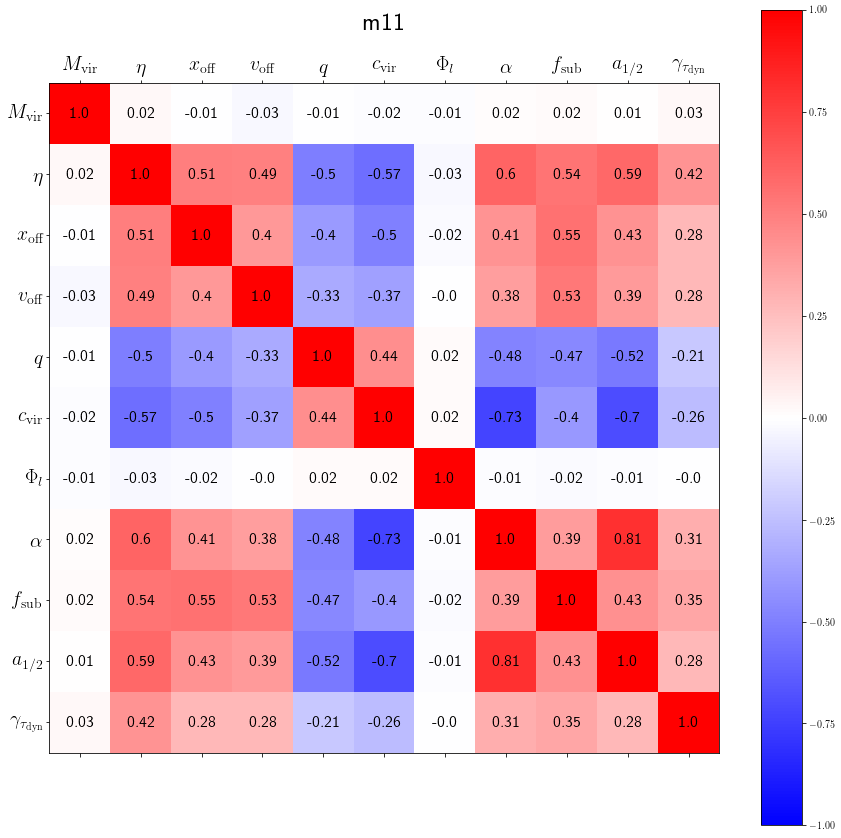

In [34]:
params = ["mvir", "eta", "x0", "v0", "q", "cvir", 'phi_l', 'alpha', 'f_sub', 'a2', 'gamma_tdyn']
hparams = {param: get_hparam(param, log=False) for param in params}
names = ['m11', 'm12']

fig, ax = plt.subplots(1, 1, figsize=(15, 15))


latex_params = [
    hparams[param].get_text(only_param=True)
    for param in params
]
values = [
    hparams[param].get_values(hcat.cat)
    for param in params
]
    
plot_correlation_matrix(ax, values, cell_text_size=16)
    
ax.set_xticks(range(len(latex_params)))
ax.set_xticklabels(latex_params, size=20)

ax.set_yticks(range(len(latex_params)))
ax.set_yticklabels(latex_params, size=20)

ax.set_title('m11', size=25, pad=20)

plt.show()
plt.tight_layout()

